# Machine Learning- Semi-supervised learning exercise

Now that you know how clustering works, let us see how it can be used in semi-supervised learning. Let us therefore take the digit image dataset.

In [1]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [2]:
X_train

array([[ 0.,  0.,  2., ...,  0.,  0.,  0.],
       [ 0.,  5., 16., ...,  6.,  1.,  0.],
       [ 0.,  0.,  4., ...,  2.,  0.,  0.],
       ...,
       [ 0.,  0.,  9., ..., 16.,  2.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  1.,  0.,  0.]], shape=(1347, 64))

In [3]:
y_train

array([5, 2, 0, ..., 2, 7, 1], shape=(1347,))

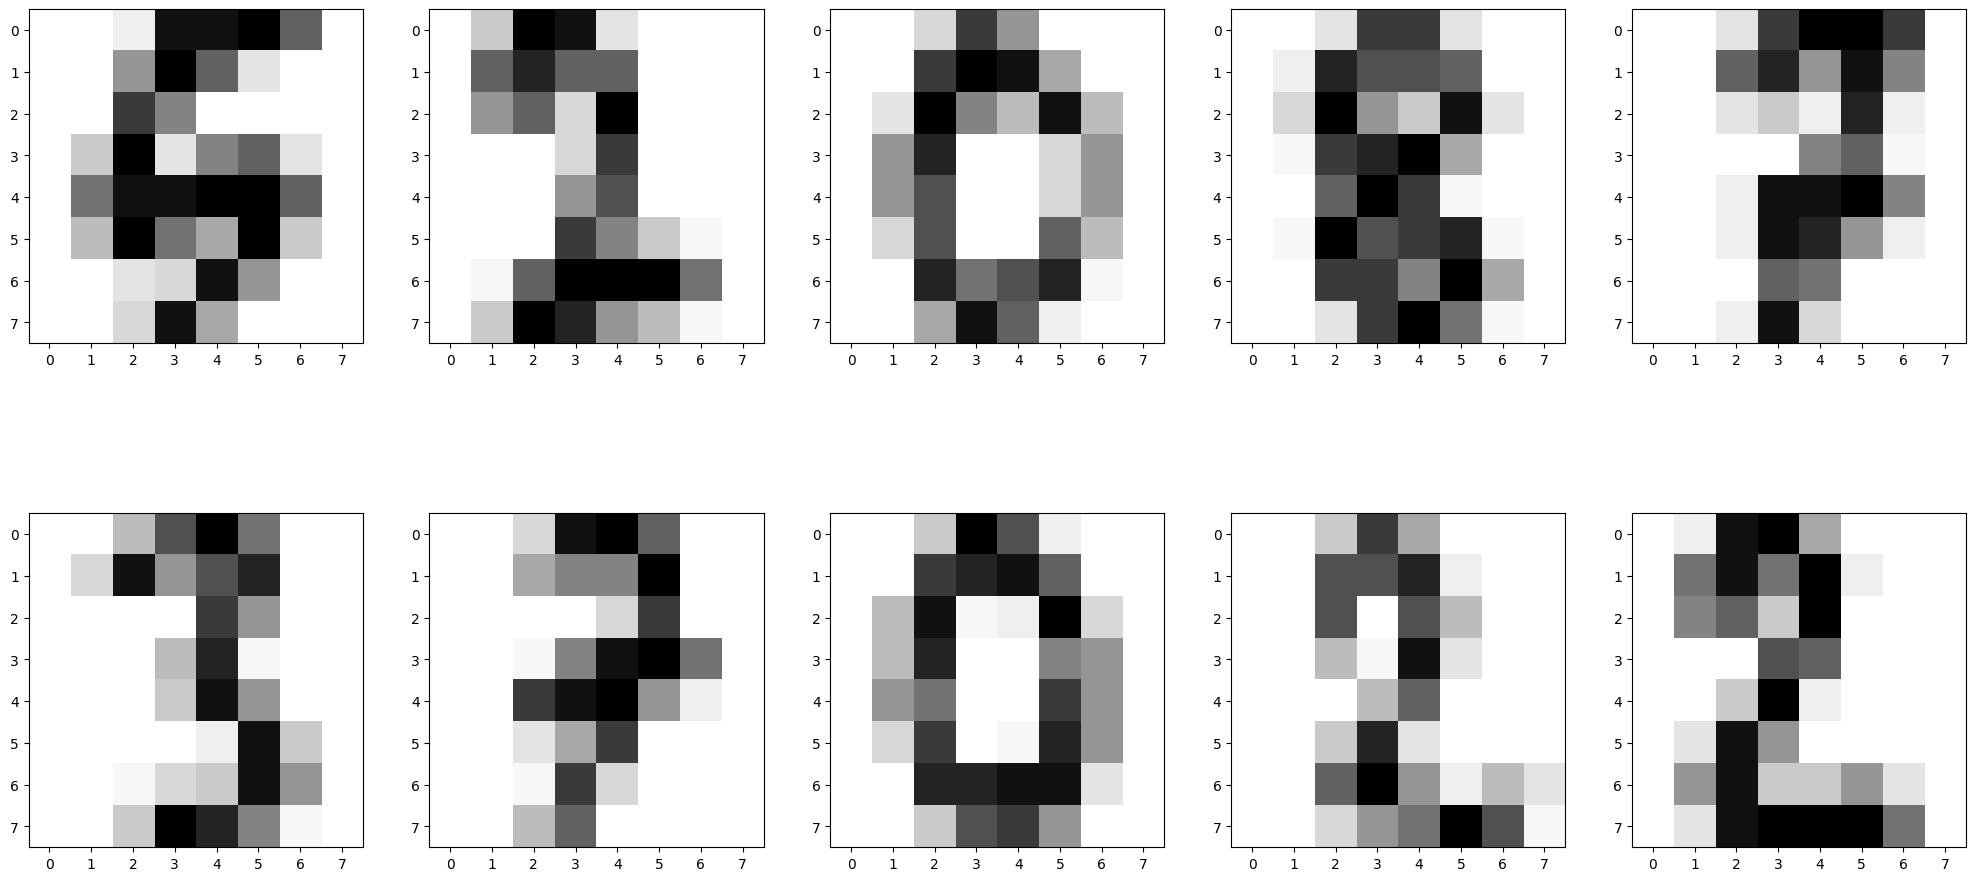

In [4]:
import matplotlib.pyplot as plt

nrows, ncols = 2, 5

# Show the 10 first elements of X_train
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 12))

for i in range(nrows):
    for j in range(ncols):
        axs[i, j].imshow(X_train[i * ncols + j].reshape(8, 8), cmap='Greys')

As a first exercise, train a RandomForestClassifier on the digit dataset, and evaluate the performance of the model (classification report + confusion matrix).

In [5]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [6]:
from sklearn.metrics import classification_report

y_pred = rfc.predict(X_test)
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        43
           1       0.97      1.00      0.99        37
           2       1.00      1.00      1.00        38
           3       0.98      0.93      0.96        46
           4       0.98      1.00      0.99        55
           5       0.94      0.98      0.96        59
           6       0.98      0.98      0.98        45
           7       0.98      0.98      0.98        41
           8       0.95      0.95      0.95        38
           9       0.98      0.94      0.96        48

    accuracy                           0.97       450
   macro avg       0.97      0.97      0.97       450
weighted avg       0.97      0.97      0.97       450



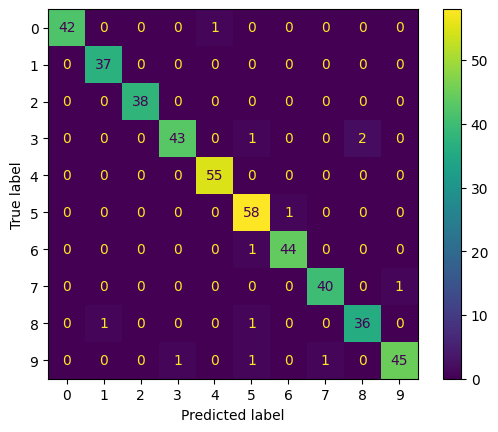

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rfc.classes_)
disp.plot()
plt.show()

Our model performs almost perfectly ! Now let us assume we only have access to 50 labeled instances. How would your model perform in this case ?

In [8]:
n_labels = 50
rfc50 = RandomForestClassifier(random_state=42)
rfc50.fit(X_train[:n_labels], y_train[:n_labels])
y_pred50 = rfc50.predict(X_test)
print(classification_report(y_test, y_pred50))

              precision    recall  f1-score   support

           0       0.66      0.98      0.79        43
           1       0.39      0.97      0.56        37
           2       0.73      0.84      0.78        38
           3       0.71      0.91      0.80        46
           4       1.00      0.09      0.17        55
           5       0.88      0.64      0.75        59
           6       0.88      0.96      0.91        45
           7       0.79      0.90      0.84        41
           8       1.00      0.13      0.23        38
           9       0.79      0.69      0.73        48

    accuracy                           0.70       450
   macro avg       0.78      0.71      0.66       450
weighted avg       0.79      0.70      0.65       450



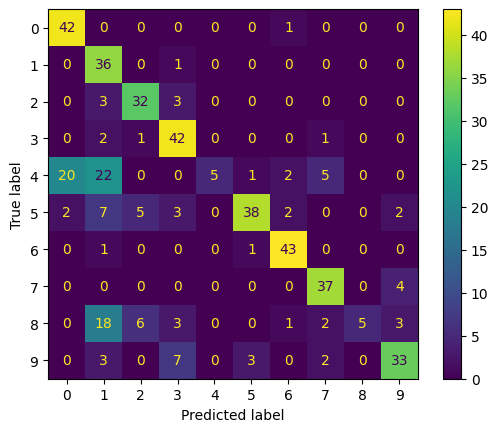

In [9]:
cm = confusion_matrix(y_test, y_pred50, labels=rfc50.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rfc50.classes_)
disp.plot()
plt.show()

Waow ! We lost roughly 25% accuracy ! But is there a way to do better by leveraging the rest of the training samples (but without looking at their labels) ?
To answer this question, let us choose a number of clusters, say 50, and for which we will fetch the closest image (this will be our representative image). Try to get those images displayed.

In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
n_clusters = 50

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_train)

closest , _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X_train)

# X_transformed = kmeans.fit_transform(X_train)
# idx = np.argmin(X_transformed, axis=0)
representative_digits = X_train[closest]

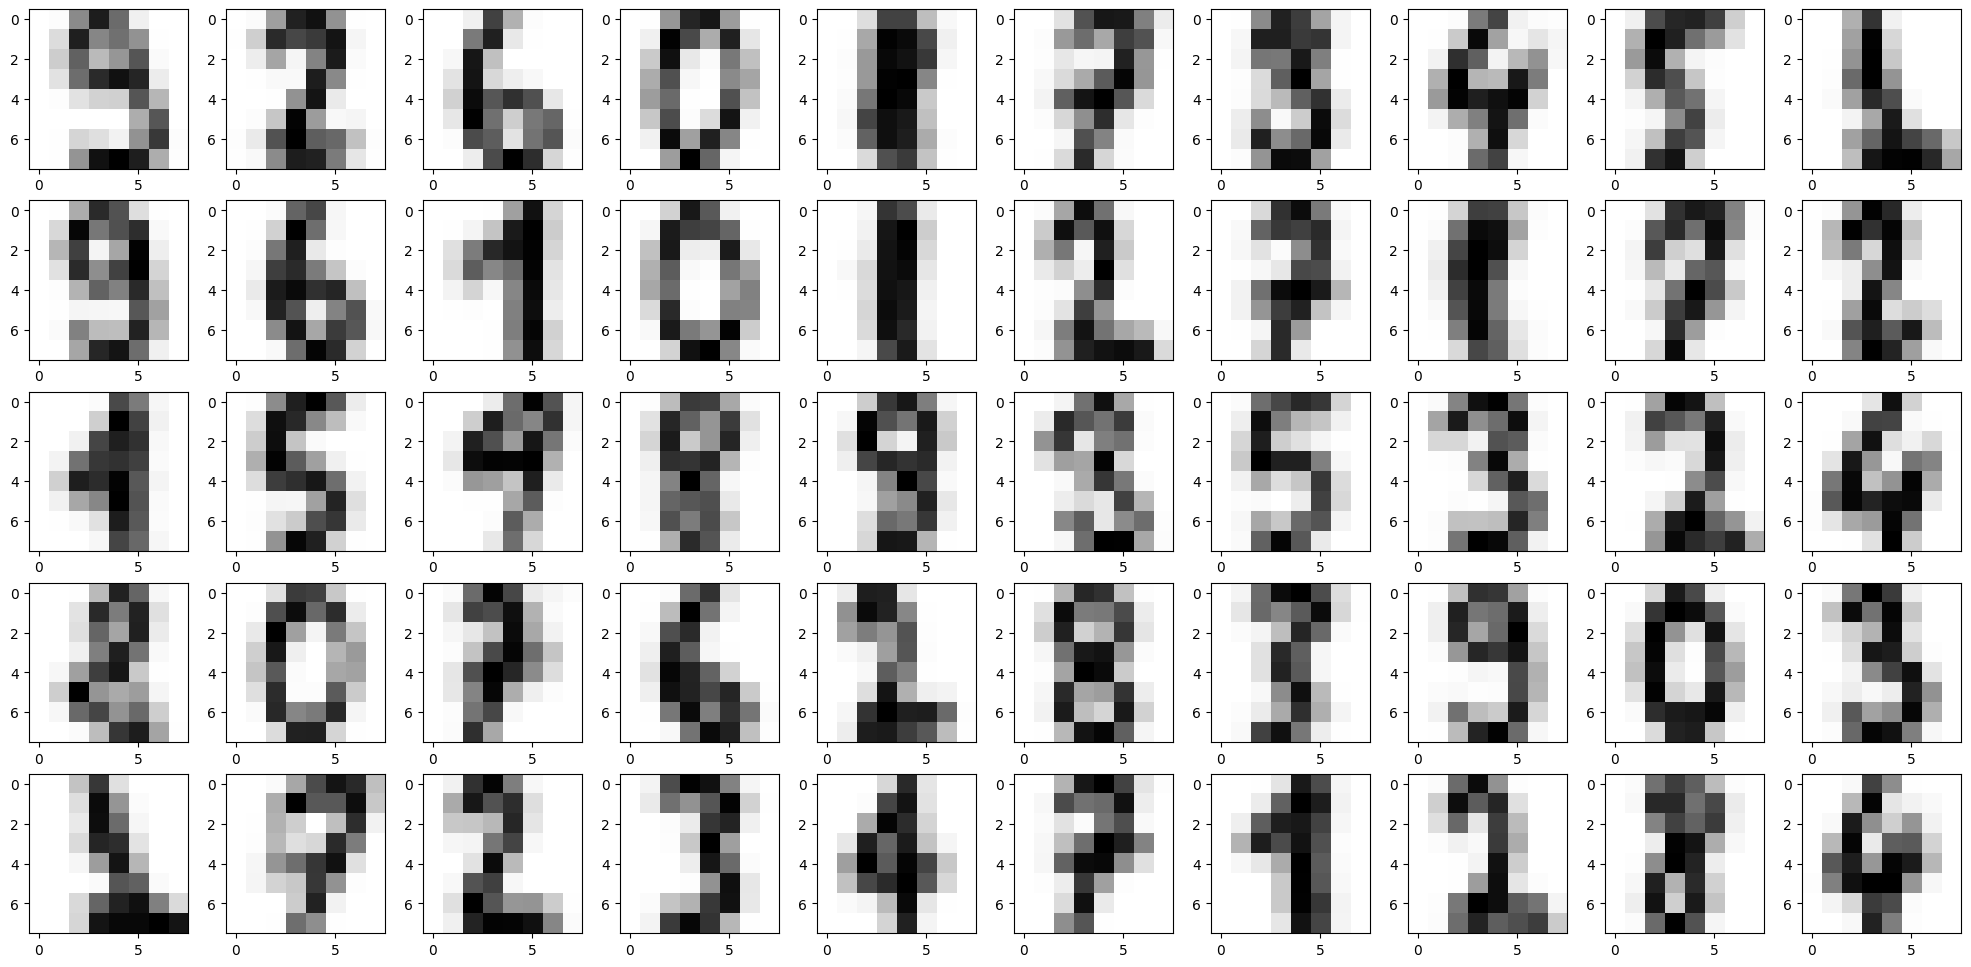

In [26]:
nrows, ncols = 5, 10

# Show the clusters computed by KMeans
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 12))

for i in range(nrows):
    for j in range(ncols):
        axs[i, j].imshow(kmeans.cluster_centers_.reshape(n_clusters, 64)[i * ncols + j].reshape(8, 8), cmap='Greys')

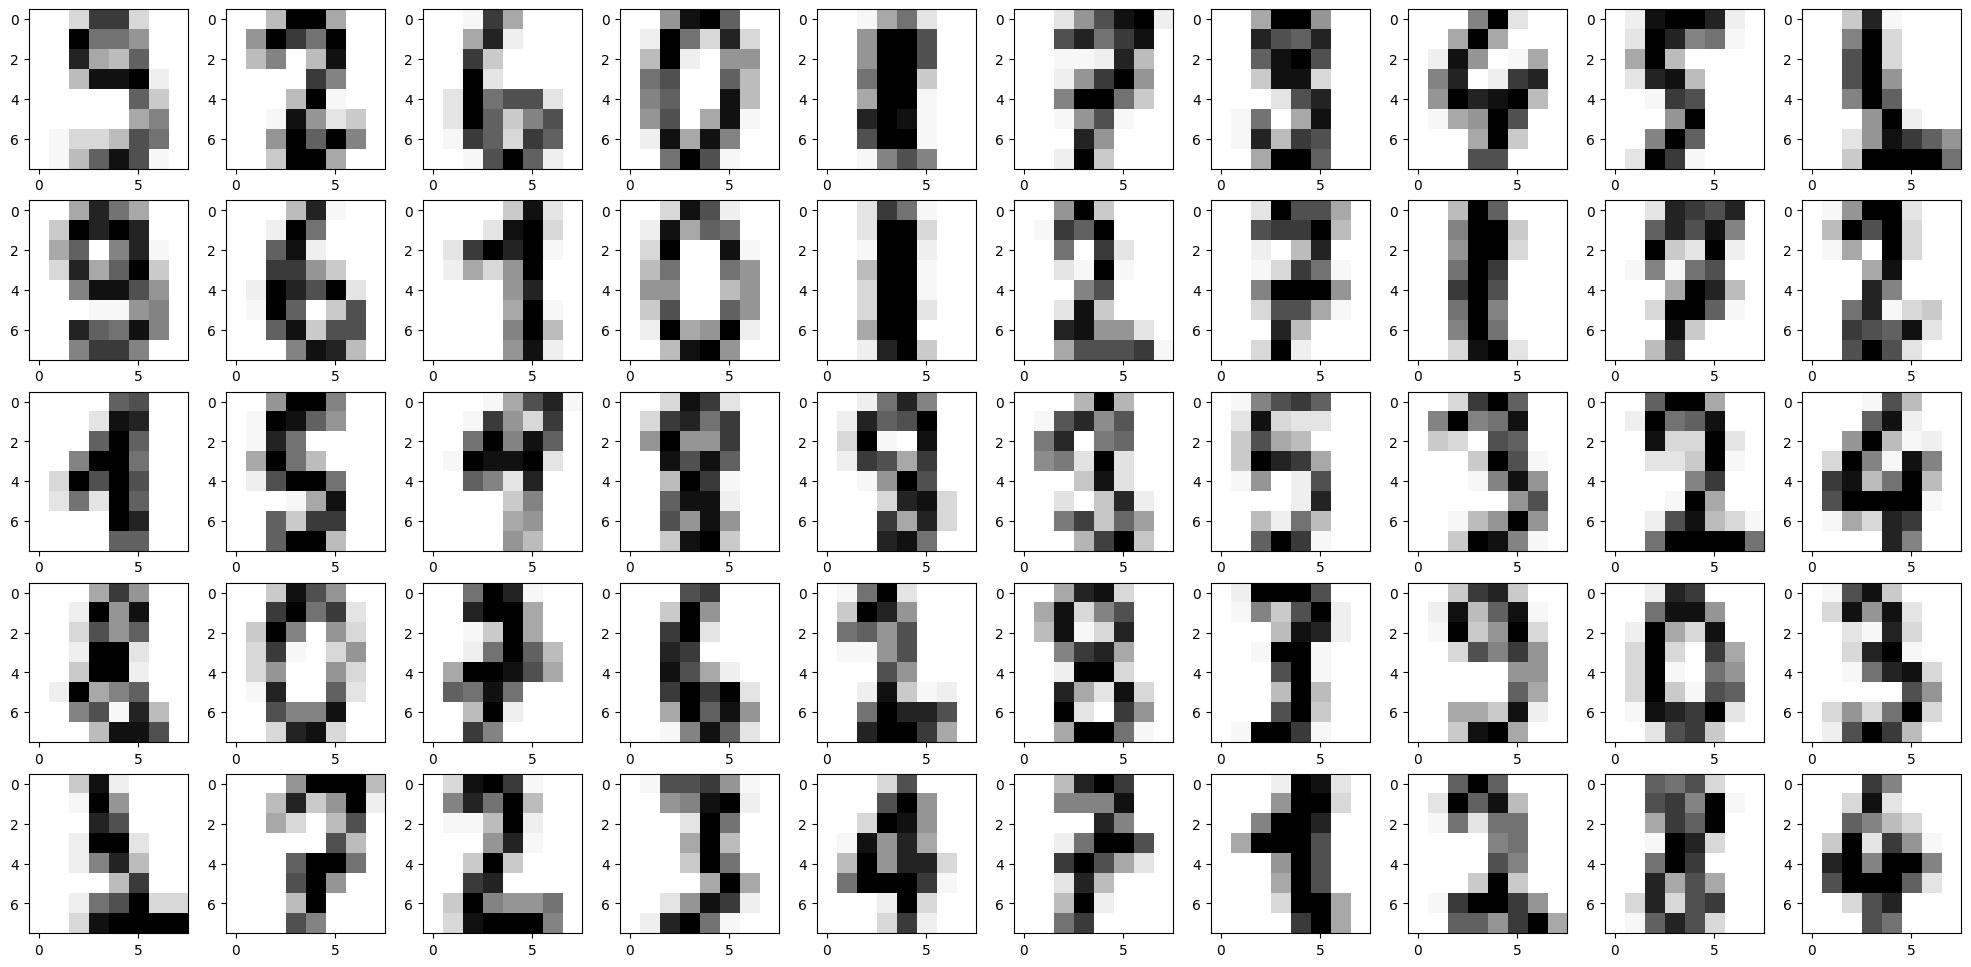

In [12]:
nrows, ncols = 5, 10

# Show the 50 digits that are the closest to their cluster
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 12))

for i in range(nrows):
    for j in range(ncols):
        axs[i, j].imshow(representative_digits[i * ncols + j].reshape(8, 8), cmap='Greys')

In [13]:
representative_digit_labels = np.array([
    [9, 2, 6, 0, 1, 7, 8, 4, 5, 1],
    [9, 6, 1, 0, 1, 2, 7, 1, 7, 2],
    [1, 5, 4, 8, 8, 3, 5, 3, 2, 4],
    [8, 0, 7, 6, 2, 8, 3, 9, 0, 3],
    [1, 7, 2, 3, 4, 7, 1, 2, 8, 4],
]).flatten()

Instead of picking 50 random instances from the training set, we now have 50 labeled instances that are actually a representative image of its cluster. Evaluate the performance of our RandomForestClassifier on that training set!

In [14]:
rfc_reduced = RandomForestClassifier(random_state=42)
rfc_reduced.fit(representative_digits, representative_digit_labels)

RandomForestClassifier(random_state=42)

In [15]:
y_pred = rfc_reduced.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89        43
           1       0.72      0.97      0.83        37
           2       0.95      0.95      0.95        38
           3       0.85      0.85      0.85        46
           4       0.84      0.85      0.85        55
           5       0.91      0.68      0.78        59
           6       0.97      0.87      0.92        45
           7       0.75      0.98      0.85        41
           8       0.69      0.76      0.72        38
           9       0.81      0.60      0.69        48

    accuracy                           0.83       450
   macro avg       0.84      0.84      0.83       450
weighted avg       0.84      0.83      0.83       450



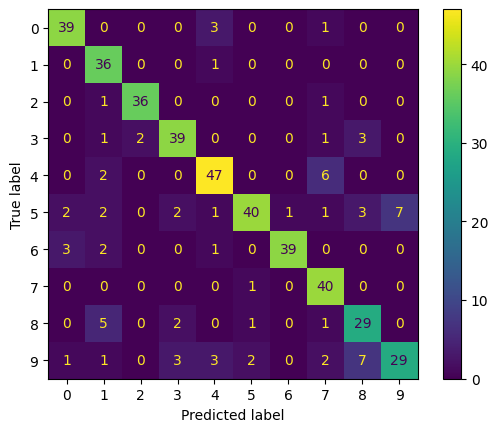

In [16]:
cm = confusion_matrix(y_test, y_pred, labels=rfc_reduced.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rfc_reduced.classes_)
disp.plot()
plt.show()

Cool ! We jumped from 70% to 83% accuracy ! But can't we do better ? Try to **propagate the labels**, i.e., assign labels to all the other instances of **the same cluster**.

In [17]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
# select instances that belong to cluster #k
masks = [kmeans.labels_ == k for k in range(n_clusters)]
for i in range(len(masks)):
    # assign to those instances the actual label that you encoded manually
    y_train_propagated[masks[i]] = representative_digit_labels[i]

In [18]:
rfc_propagated = RandomForestClassifier(random_state=42)
rfc_propagated.fit(X_train, y_train_propagated)

RandomForestClassifier(random_state=42)

In [19]:
print(classification_report(y_test, rfc_propagated.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        43
           1       0.93      1.00      0.96        37
           2       1.00      0.95      0.97        38
           3       1.00      0.98      0.99        46
           4       0.93      0.96      0.95        55
           5       0.96      0.90      0.93        59
           6       0.98      0.98      0.98        45
           7       0.93      1.00      0.96        41
           8       0.86      0.95      0.90        38
           9       0.89      0.81      0.85        48

    accuracy                           0.95       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.95      0.95      0.95       450



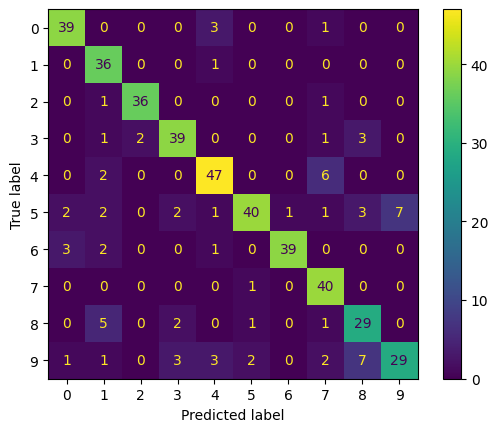

In [20]:
cm = confusion_matrix(y_test, y_pred, labels=rfc_propagated.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rfc_propagated.classes_)
disp.plot()
plt.show()

We improved our results by another 12% in accuracy ! How could you enhance this result even more ?

You could apply this technique to all instances **except** the ones that lie close to decision boundaries. For this, you could put a threshold, say 20%, of the total amount of instances of a given cluster that you actually label like this (i.e. you take the quantile that lies the closest to its cluster - that is, the one you are the most confident about). This would give you an exta boost of possibly a few percents!

In [32]:
y_train_propagated_bis = np.full(len(X_train), -1, dtype=np.int32)
masks = [kmeans.labels_ == k for k in range(n_clusters)]

for k in range(n_clusters):
    # Get mask and indices for current cluster
    cluster_mask = (kmeans.labels_ == k)
    cluster_indices = np.where(cluster_mask)[0]

    # Get samples in cluster
    cluster_samples = X_train[cluster_indices]

    # Compute distance to cluster center
    distances = np.linalg.norm(cluster_samples - kmeans.cluster_centers_[k], axis=1)

    # Sort indices by distance (ascending → closest to center first)
    sorted_idx = np.argsort(distances)

    # Select top 20% closest samples
    top_n = max(1, int(0.2 * len(sorted_idx)))  # at least 1
    selected_indices = cluster_indices[sorted_idx[:top_n]]

    # Assign the cluster's representative label to only the closest ones
    y_train_propagated_bis[selected_indices] = representative_digit_labels[k]


In [33]:
rfc_propagated = RandomForestClassifier(random_state=42)
rfc_propagated.fit(X_train, y_train_propagated_bis)

RandomForestClassifier(random_state=42)

In [34]:
print(classification_report(y_test, rfc_propagated.predict(X_test),zero_division=0))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       0.0
           0       0.00      0.00      0.00      43.0
           1       0.00      0.00      0.00      37.0
           2       0.00      0.00      0.00      38.0
           3       0.00      0.00      0.00      46.0
           4       0.00      0.00      0.00      55.0
           5       0.00      0.00      0.00      59.0
           6       0.00      0.00      0.00      45.0
           7       0.00      0.00      0.00      41.0
           8       0.00      0.00      0.00      38.0
           9       0.00      0.00      0.00      48.0

    accuracy                           0.00     450.0
   macro avg       0.00      0.00      0.00     450.0
weighted avg       0.00      0.00      0.00     450.0

